In [1]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"

import numpy as np
import torch
import matplotlib.pyplot as plt
from helper_fn import *


label_path = PATH + "track_datasets/control_mm/train/labels/"

In [2]:
# for each file in directory load the .npy file and append to a list
import os
import sys


def load_labels(label_path):
    labels = []
    for file in os.listdir(label_path):
        if file.endswith(".npy"):
            tr = np.load(label_path + file).squeeze().T
            if tr.shape[0] < 100:
                continue
            labels.append(tr)
    return labels


tracks = load_labels(label_path)

(218, 2)


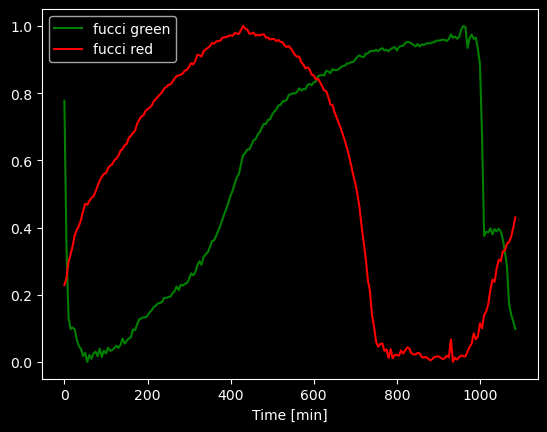

In [3]:
ind = np.random.randint(0, len(tracks))

print(tracks[ind].shape)

plot_fucci(tracks[ind])

In [4]:
tau = []
# tau is a linspace between 0 and 1 with the tracks length as the number of points
for i in range(len(tracks)):
    tau.append(np.linspace(0, 1, tracks[i].shape[0]))

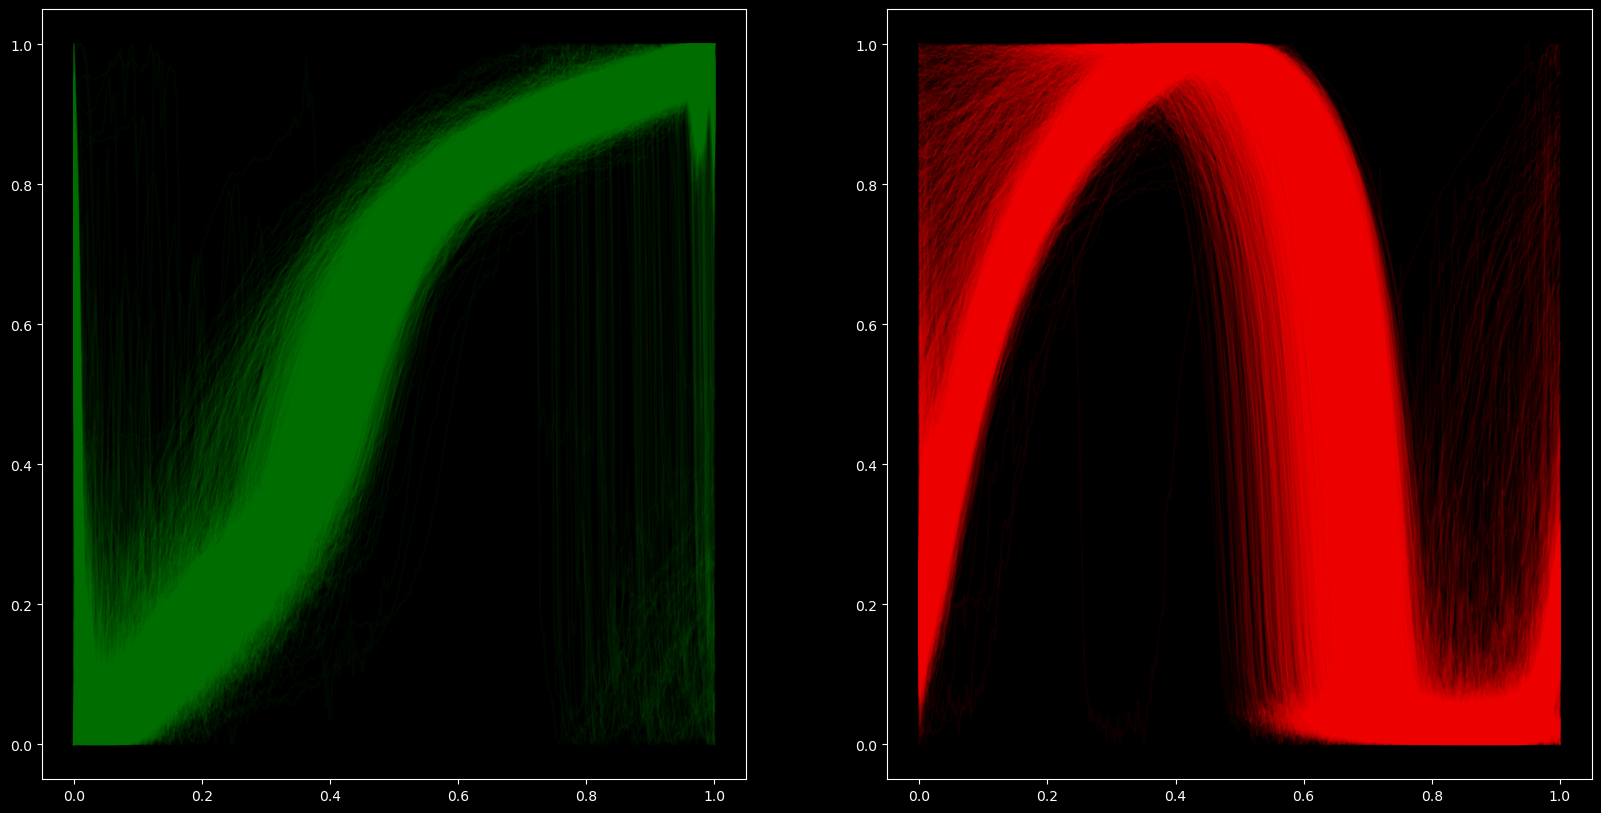

In [5]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
for i, track in enumerate(tracks):
    plt.plot(tau[i], track[:, 0], c="g", alpha=0.05)

plt.subplot(1, 2, 2)
for i, track in enumerate(tracks):
    plt.plot(tau[i], track[:, 1], c="r", alpha=0.05)

# Finding a reference

## DTW distance 

With this approach I use the cost function of the warping distance, and take the one which has the smallest sum of distance to the other tracks

In [6]:
from dtaidistance import dtw, dtw_ndim, dtw_ndim_visualisation
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np

# 1000 random track indeices, no repeats
# ind = np.random.randint(0, len(tracks), 1000)


# # compute the distance matrix
ds = dtw.distance_matrix_fast(tracks[:1000])
print(ds.shape)

(1000, 1000)


In [7]:
dist_ranking = ds.sum(axis=1)
best_tr_DTW = dist_ranking.argmin()

Text(0.5, 1.0, 'mean distance 1.4972196638429465')

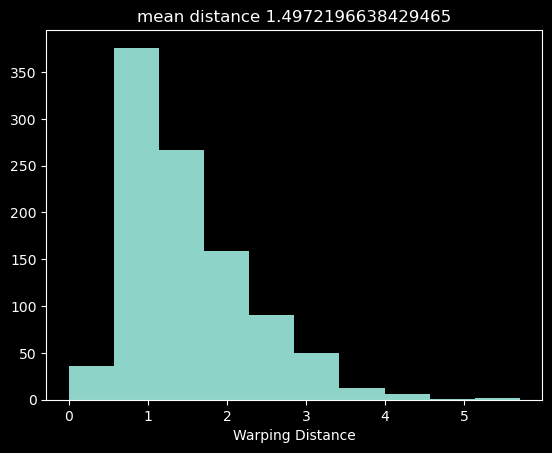

In [8]:
plt.hist(ds[:, best_tr_DTW])
plt.xlabel("Warping Distance")
plt.title(f"mean distance {ds[:, best_tr_DTW].mean()}")

Text(0.5, 1.0, 'Most avarage track according to DTW')

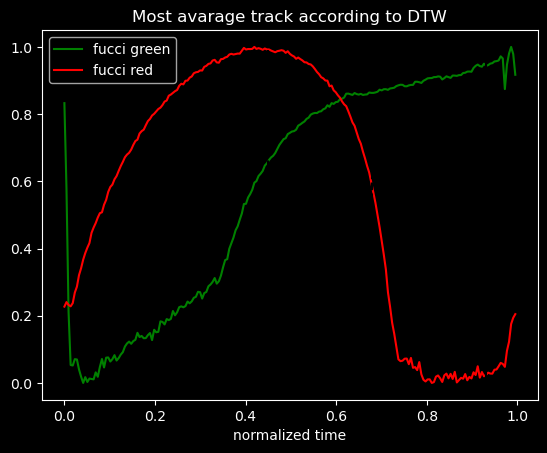

In [9]:
plot_fucci(tracks[best_tr_DTW], time="normalized")
plt.title("Best track according to DTW")

# vertical line
plt.axvline(x=0.45, color="k", linestyle="--")
plt.axvline(x=0.68, color="k", linestyle="--")
plt.axvline(x=0.93, color="k", linestyle="--")

plt.title("Most avarage track according to DTW")

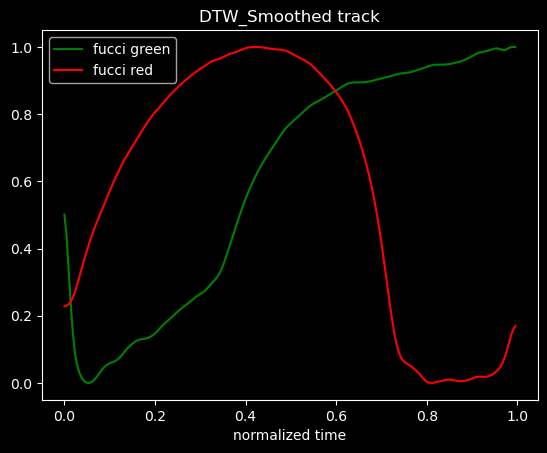

In [10]:
# smooth the track with a gaussian filter

from scipy.ndimage import gaussian_filter1d

DTW_smoothed = gaussian_filter1d(tracks[best_tr_DTW], sigma=2.3, axis=0)
plt.title("DTW_Smoothed track")

# min max normalization
DTW_smoothed = (DTW_smoothed - DTW_smoothed.min(axis=0)) / (
    DTW_smoothed.max(axis=0) - DTW_smoothed.min(axis=0)
)

plot_fucci(DTW_smoothed, time="normalized")

In [11]:
DTW_ref = tracks[best_tr_DTW]
dtw_tau = np.linspace(0, 1, DTW_ref.shape[0])
# define a rolling variance

print(DTW_ref.shape, DTW_smoothed.shape)

(217, 2) (217, 2)


# approximation: splines

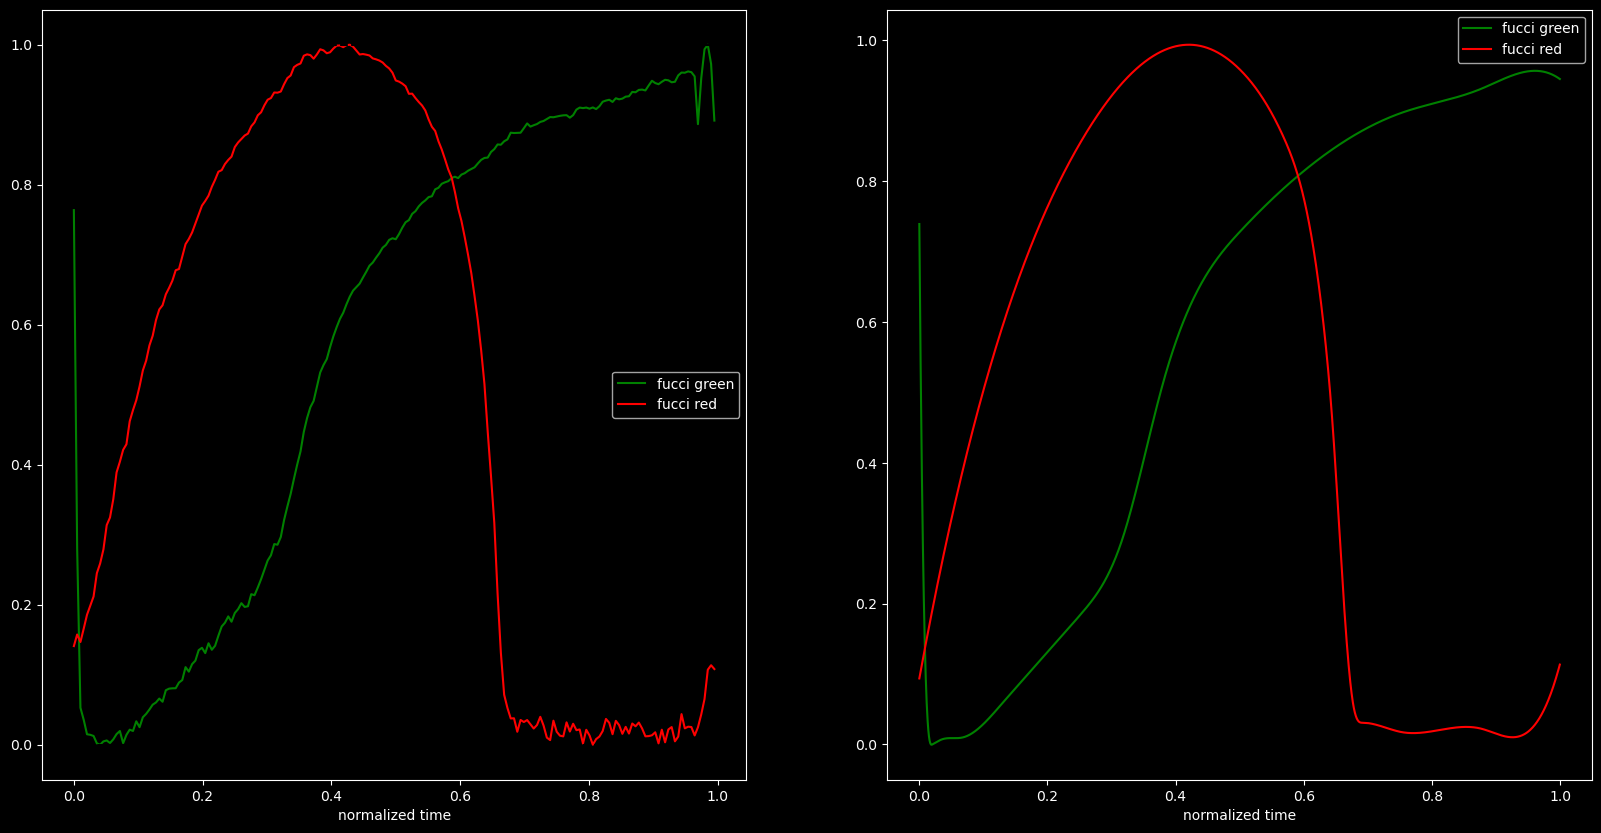

In [ ]:
# spline fit of DTW_ref
from scipy.interpolate import UnivariateSpline

# useign 20 points
smoothig_param = 0.02

tr_ind = np.random.randint(0, len(tracks))

cs = UnivariateSpline(tau[tr_ind], tracks[tr_ind][:, 0], s=smoothig_param)
cs2 = UnivariateSpline(tau[tr_ind], tracks[tr_ind][:, 1], s=smoothig_param)


tau_span = np.linspace(0, 1.0, 2000)

dtw_ref_hat = np.zeros((tau_span.shape[0], 2))
dtw_ref_hat[:, 0] = cs(tau_span)
dtw_ref_hat[:, 1] = cs2(tau_span)

# double plot on left actual track on right smoothed track
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plot_fucci(tracks[tr_ind], time="normalized")
plt.axhline(y=1.0, color="k", linestyle="--")
plt.axhline(y=0.0, color="k", linestyle="--")
plt.subplot(1, 2, 2)
plot_fucci(dtw_ref_hat, time="normalized")

/tmp/ipykernel_2469797/4150967693.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


[0.00980175 0.01466525] [0.98079282 0.99418099]


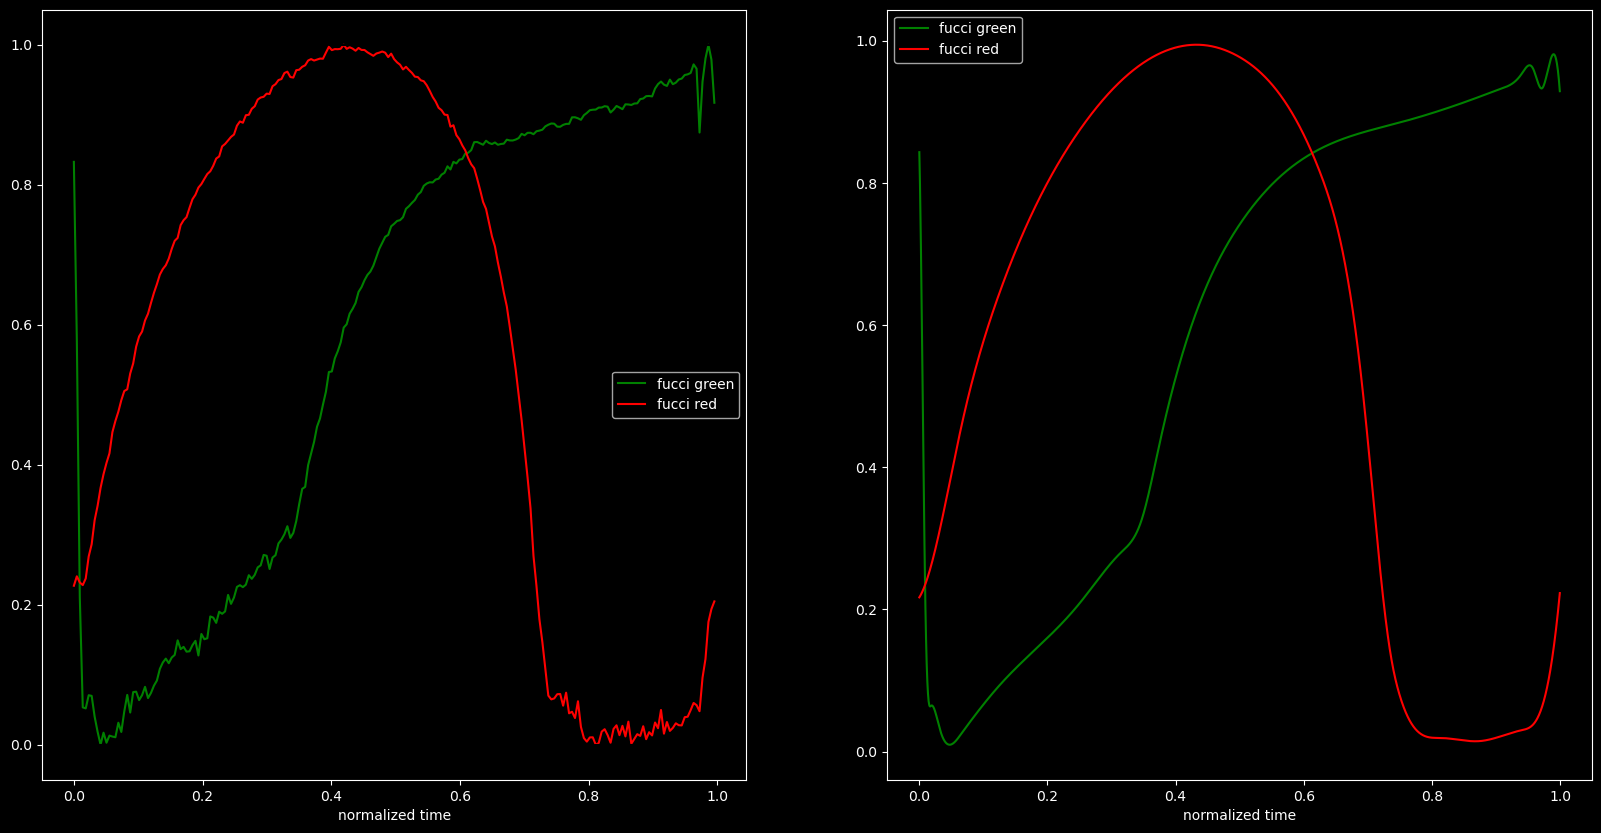

In [ ]:
smoothig_param = 0.02

cs = UnivariateSpline(dtw_tau, DTW_ref[:, 0], s=smoothig_param)
cs2 = UnivariateSpline(dtw_tau, DTW_ref[:, 1], s=smoothig_param)


tau_span = np.linspace(0, 1.0, 2000)

dtw_ref_hat = np.zeros((tau_span.shape[0], 2))
dtw_ref_hat[:, 0] = cs(tau_span)
dtw_ref_hat[:, 1] = cs2(tau_span)

# double plot on left actual track on right smoothed track
plt.figure(figsize=(20, 10))
plt.title("DTW reference track + splines")
plt.subplot(1, 2, 1)
plot_fucci(DTW_ref, time="normalized")
plt.axhline(y=1.0, color="k", linestyle="--")
plt.axhline(y=0.0, color="k", linestyle="--")
plt.subplot(1, 2, 2)
plot_fucci(dtw_ref_hat, time="normalized")

print(dtw_ref_hat.min(0), dtw_ref_hat.max(0))

In [ ]:
def get_vanilla_fn(tracks, tau, smoothig_param=0.02):
    """
    Function that returns a spline fit of the mean track
    """
    # compute the mean track
    mean_track = np.mean(tracks, axis=0)
    cs = UnivariateSpline(tau, mean_track[:, 0], s=smoothig_param)
    cs2 = UnivariateSpline(tau, mean_track[:, 1], s=smoothig_param)
    tau_span = np.linspace(0, 1.0, 2000)
    mean_track_hat = np.zeros((tau_span.shape[0], 2))
    mean_track_hat[:, 0] = cs(tau_span)
    mean_track_hat[:, 1] = cs2(tau_span)
    return mean_track_hat

In [16]:
cs.get_knots()
cs.get_coeffs()
cs.get_residual()

0.019981282214589557

# fourier regression

check that coef didnt explode 0.6022100242919707 -0.4290397864772492


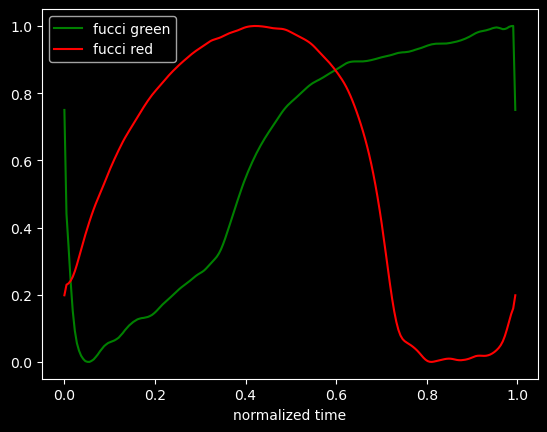

In [70]:
n_harmonics = 105
coef0, dtw_fourier0 = linear_regression(dtw_tau, DTW_smoothed[:, 0], n_harmonics=n_harmonics)
coef1, dtw_fourier1 = linear_regression(dtw_tau, DTW_smoothed[:, 1], n_harmonics=n_harmonics)

coef = np.zeros((coef0.shape[0], 2))
coef[:, 0] = coef0
coef[:, 1] = coef1

dtw_fourier = np.zeros((dtw_fourier0.shape[0], 2))
dtw_fourier[:, 0] = dtw_fourier0
dtw_fourier[:, 1] = dtw_fourier1

plot_fucci(dtw_fourier, time="normalized")

print("check that coef didnt explode", coef.max(), coef.min())

In [72]:
import torch
print(coef.shape, dtw_fourier.shape)
coef_torch = torch.tensor(coef, dtype=torch.float32)
coef_torch.dtype

(211, 2) (217, 2)


torch.float32

torch.float32
torch.Size([1, 217, 2])


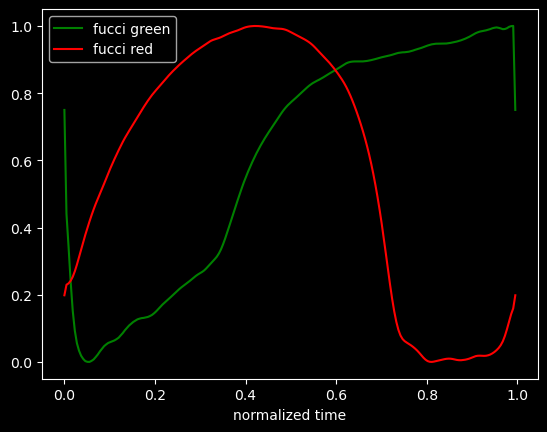

In [73]:
def vanilla_fn(tau):

    n_harmonics = (coef_torch.shape[0] - 1) // 2
    k_values = torch.arange(1, n_harmonics + 1, device=tau.device).float()

    # Fourier Design Matrix
    A = torch.ones((tau.shape[0], tau.shape[1], 1 + 2 * n_harmonics))
    print(A.dtype)
    # B x S x (P-1)/2
    cosine_terms = torch.cos(2 * torch.pi * k_values[None, None, :] * tau[:, :, None])
    sine_terms = torch.sin(2 * torch.pi * k_values[None, None, :] * tau[:, :, None])
    A[:, :, 1::2] = cosine_terms
    A[:, :, 2::2] = sine_terms

    # Get Vanilla Prediction
    # vanilla_prediction = A @ coef_torch
    vanilla_prediction = torch.einsum("bsp,pf->bsf", A, coef_torch)

    return A, vanilla_prediction


taus = torch.linspace(0, 1, len(dtw_tau))[None, :]
A, vanilla_pred = vanilla_fn(taus)

print(vanilla_pred.shape)

plot_fucci(vanilla_pred.squeeze().detach().numpy(), time="normalized")

In [74]:
# save dtw_fourier
np.save("coef_fourier.npy", coef)

# vanilla prediction


In [ ]:
# ds2 = dtw.distance_fast(tracks[0], fourier_ref)

ds2 = dtw_ndim.distance_fast(tracks[0], fourier_ref)

w_dist_fourier = np.zeros(len(tracks))

for i, track in enumerate(tracks):
    ds2 = dtw_ndim.distance_fast(track, fourier_ref)
    w_dist_fourier[i] = ds2

Text(0.5, 1.0, 'mean distance 1.2842275022204428')

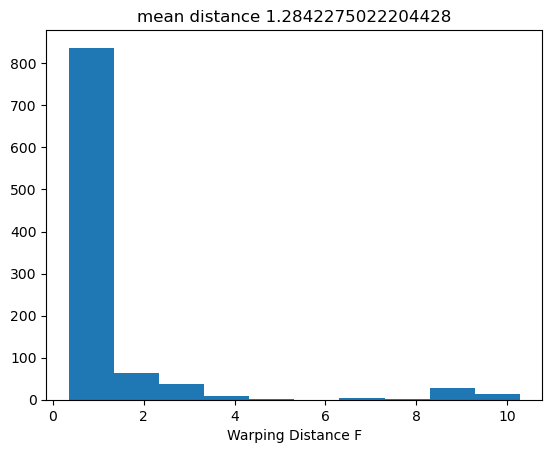

In [52]:
# do the same hist as before
plt.hist(w_dist_fourier)
plt.xlabel("Warping Distance F")
plt.title(f"mean distance {w_dist_fourier.mean()}")

# DTW

Once determined a reference track, let's use DTW to deterin the alignment, that wil later used do pass from normalized time to the phase.


In [ ]:
track0 = tracks[0]

In [ ]:
fourier_ref.shape

(219, 2)

438
(211, 2) (116, 2)


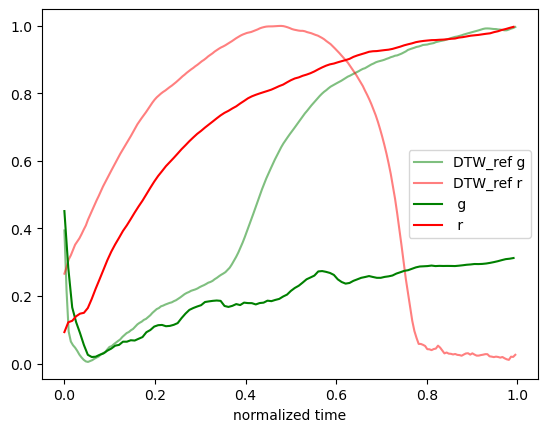

In [ ]:
idx = np.random.choice(len(tracks))
# idx= 930
print(idx)
track0 = tracks[idx]

window_size = int(0.1 * len(DTW_ref))

# warping with DTW_ref
d, wpath = dtw_ndim.warping_paths(DTW_ref, track0, window=window_size)
best_path = np.array(dtw.best_path(wpath))
# warping with fourier_ref
d2, wpath2 = dtw_ndim.warping_paths(fourier_ref, track0, window=window_size)
best_path2 = np.array(dtw.best_path(wpath2))


print(DTW_ref.shape, track0.shape)

plot_fucci(DTW_ref, time="normalized", label="DTW_ref", alpha=0.5)
plot_fucci(track0, time="normalized")

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

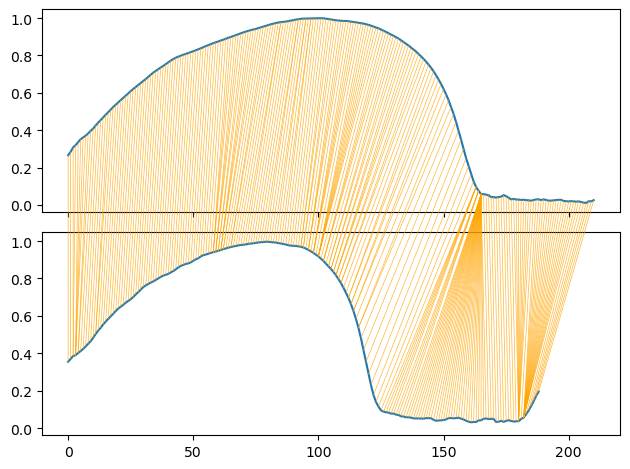

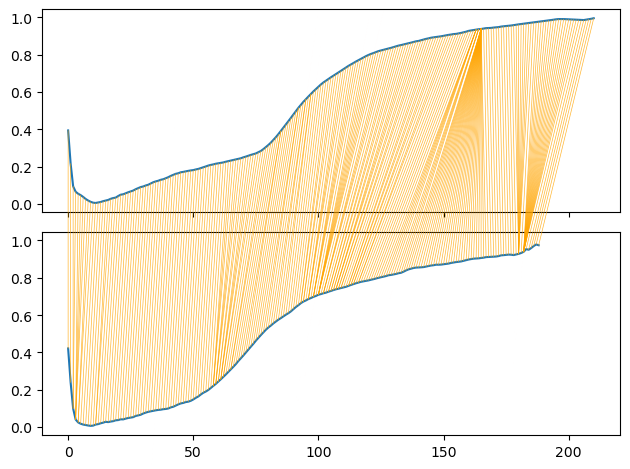

In [ ]:
# dtw_visualisation.plot_warping(DTW_ref[:,0], track0[:,0], best_path, filename="warp.png")

dtw_visualisation.plot_warping(DTW_ref[:, 1], track0[:, 1], best_path)
dtw_visualisation.plot_warping(DTW_ref[:, 0], track0[:, 0], best_path)

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

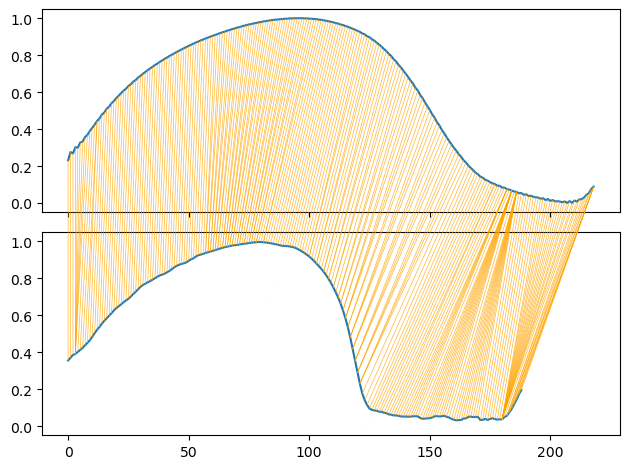

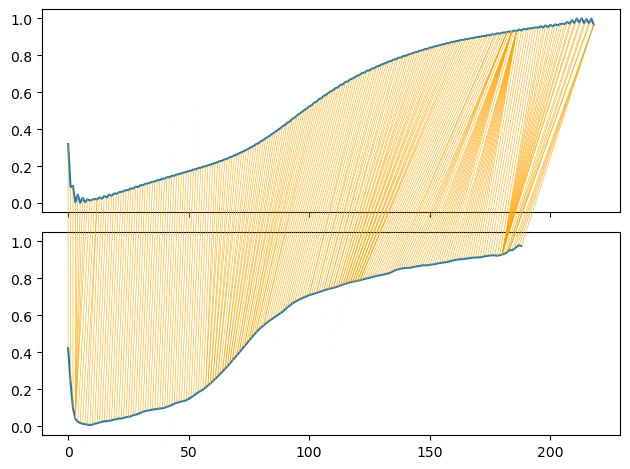

In [ ]:
dtw_visualisation.plot_warping(fourier_ref[:, 1], track0[:, 1], best_path2)
dtw_visualisation.plot_warping(fourier_ref[:, 0], track0[:, 0], best_path2)

In [ ]:
# s0 = np.array([0,0,0,0,0,0,0,2,2,0,0])
# s1 = np.array([0,4,4,4, 0,0,0,0])

# d, paths = dtw.warping_paths(s0, s1)
# best_path = dtw.best_path(paths)

# dtw_visualisation.plot_warping(s0, s1, best_path)

# best_path

Here the idea is to study the relative speed

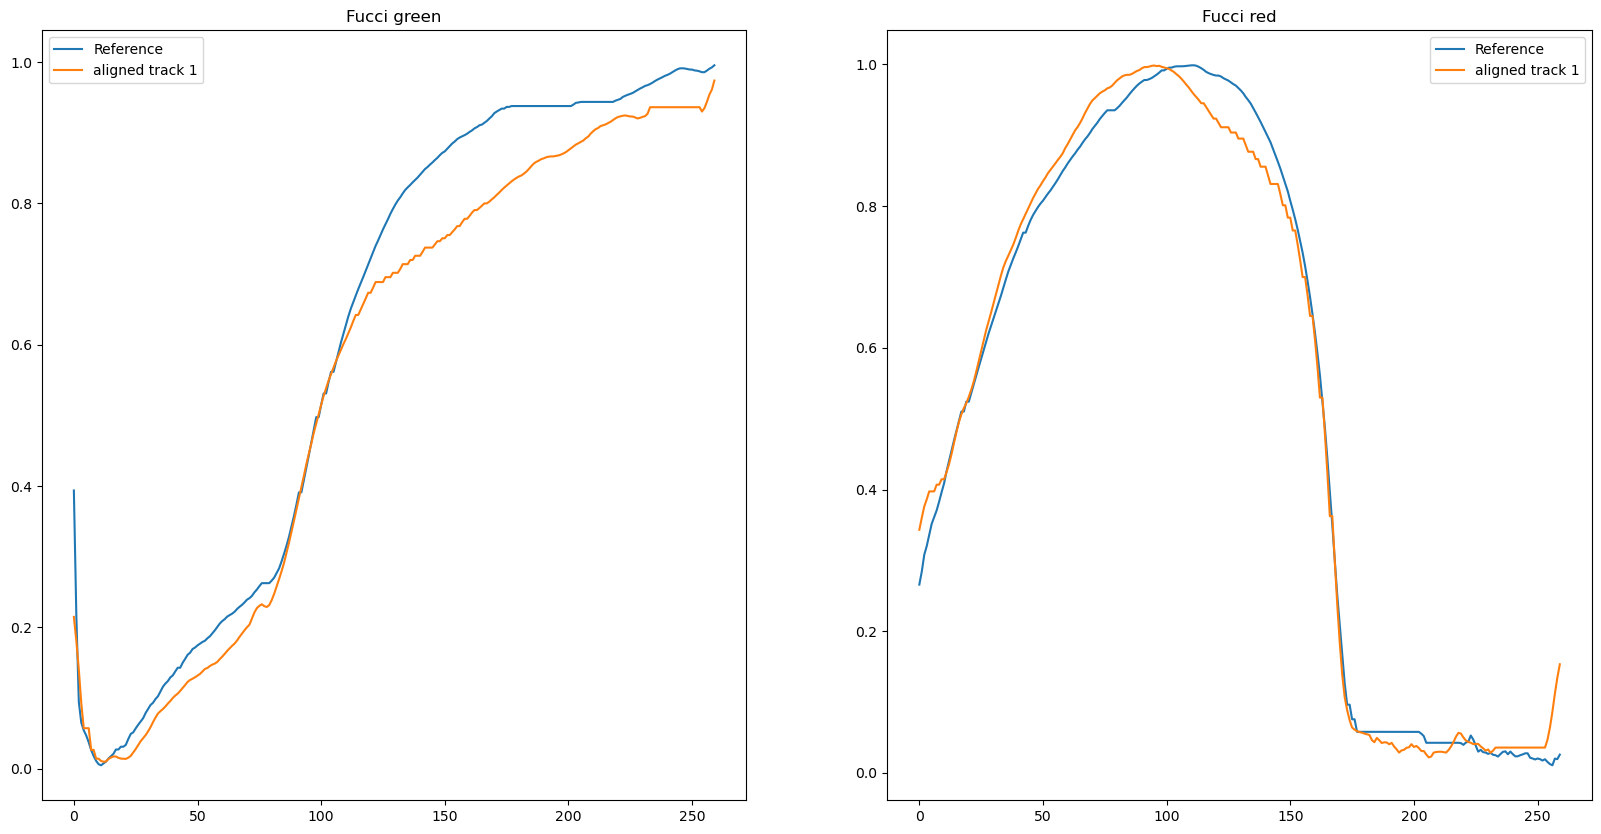

In [ ]:
aligned_series_0 = np.array([DTW_ref[p[0], :] for p in best_path])
aligned_series_1 = np.array([track0[p[1], :] for p in best_path])

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Fucci green")
plt.plot(aligned_series_0[:, 0], label="Reference")
plt.plot(aligned_series_1[:, 0], label="aligned track 1")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Fucci red")
plt.plot(aligned_series_0[:, 1], label="Reference")
plt.plot(aligned_series_1[:, 1], label="aligned track 1")
plt.legend()

In [ ]:
# get phases of all tracks with .apply
all_phases = [track2phase(track, fourier_ref) for track in tracks[:100]]

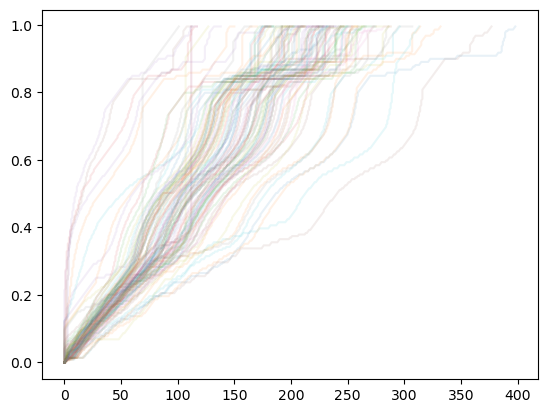

In [ ]:
for i, track in enumerate(all_phases):
    plt.plot(track[:, 0], track[:, 1], label=f"track {i}", alpha=0.1)

# phase study

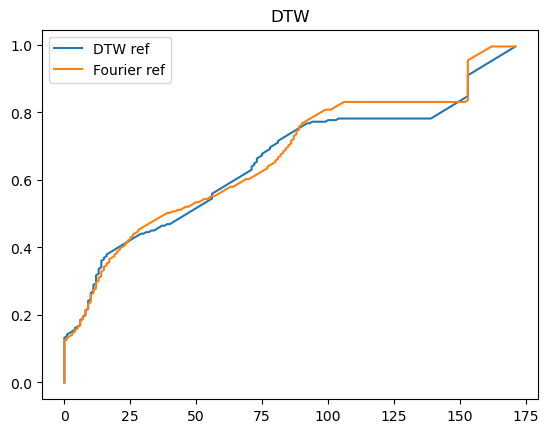

In [ ]:
track0 = tracks[np.random.choice(len(tracks))]
tr_ph = track2phase(track0, DTW_ref)
plt.title("DTW")
plt.plot(tr_ph[:, 0], tr_ph[:, 1], label="DTW ref")

tr_ph = track2phase(track0, fourier_ref)

plt.plot(tr_ph[:, 0], tr_ph[:, 1], label="Fourier ref")
plt.legend()